In [124]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt
from scipy.signal import czt
from scipy.optimize import least_squares
from scipy.signal import spectrogram
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#read data
file_path = './FMCW Radar/Rawdata/Rawdata_1.csv'
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]


In [3]:
T_c = 91.72 * (1e-6)   # Chirp time
f_start = 60.25*(1e9)  # Hz
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
RANGE_RESOLUTION=4 # 4cm
MAX_RANGE=1100#11 m = 1100 cm
speed_of_light = 299792458

![Screenshot 2023-11-03 at 1.12.06 PM.png](<attachment:Screenshot 2023-11-03 at 1.12.06 PM.png>)

In [4]:
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP] for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP)]
chirps_frame =[chirps[j] for j in range(0, len(chirps), 2)]
print(np.array(chirps_frame).shape)
chirps_frame_shape = np.array(chirps_frame).shape

(6000, 256)


In [85]:
# calculate range profile
NFFT=256
range_profile =[np.fft.fft(chirp,NFFT) for chirp in chirps_frame]
range_profile_shape = np.array(range_profile).shape
print(range_profile_shape)

(6000, 256)


In [86]:
#calculate estimated background
range_bin = range_profile_shape[1]
frame_number =range_profile_shape[0]
estimated_background_range_profile = np.zeros(range_bin,dtype=complex)
for bin_index in range (0,range_bin):
    estimated_background_range_profile[bin_index] = np.average(np.array(range_profile)[:,bin_index])
print("background estimation: ",estimated_background_range_profile.shape)

background estimation:  (256,)


In [87]:
removal_background_range_profile =np.zeros_like(range_profile)
frame_number =range_profile_shape[0]
for  bin_index in range (0,range_bin):
    for frame_index in range(0,frame_number):
        removal_background_range_profile [frame_index][bin_index] = range_profile[frame_index][bin_index] - estimated_background_range_profile[bin_index]
print("background removal range profile: ",removal_background_range_profile.shape)   

background removal range profile:  (6000, 256)


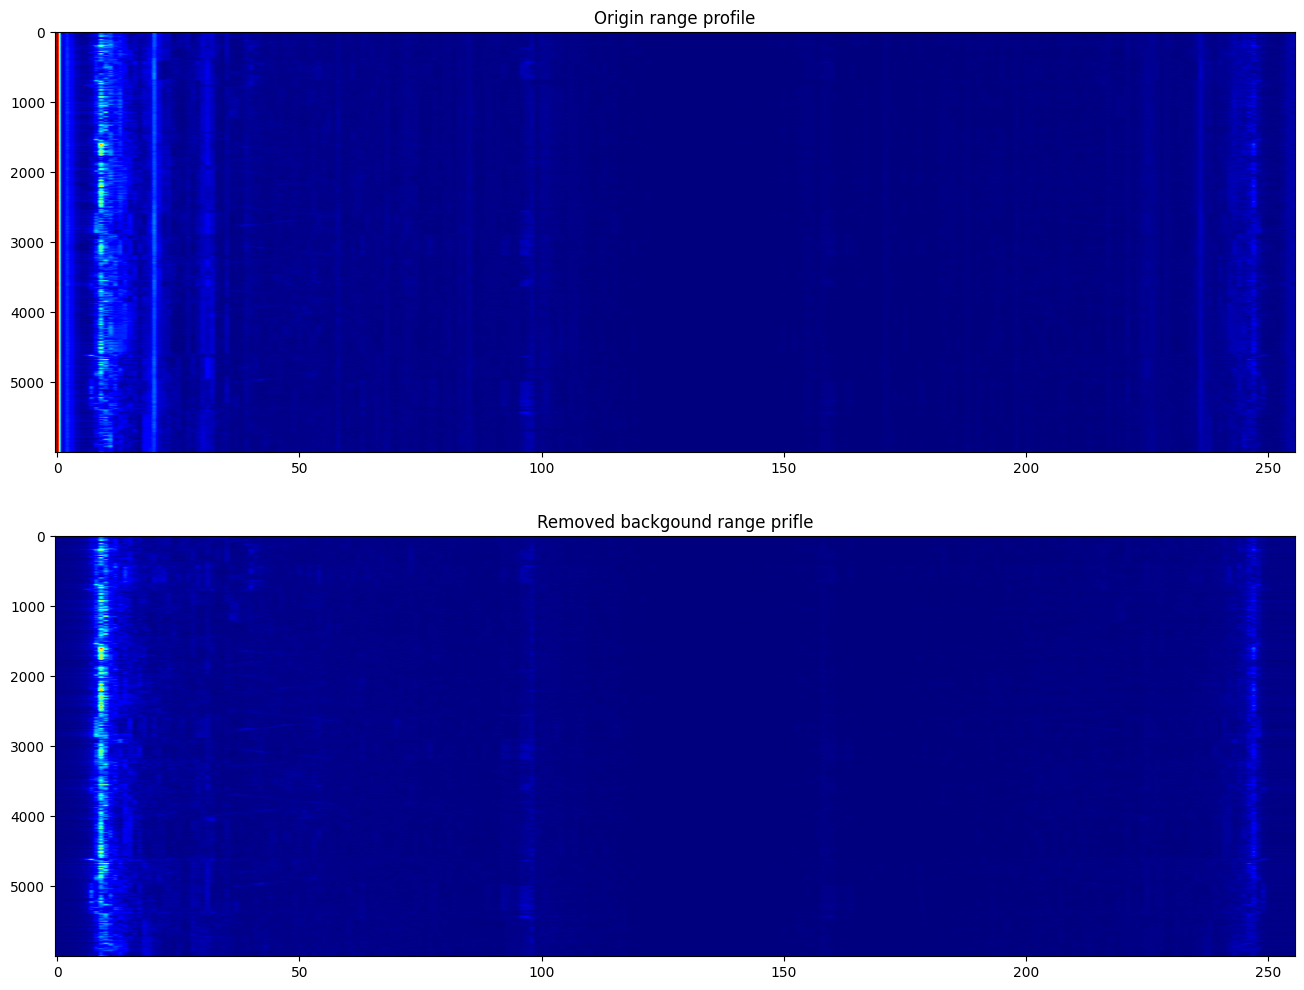

In [88]:
magnitude_range_profile = [np.abs(profile) for profile in range_profile]
magnitude_removal_background_range_profile =[np.abs(rm_backrange)  for rm_backrange in removal_background_range_profile]
plt.figure(figsize=(16,12))
plt.subplot(211)
plt.imshow(magnitude_range_profile,aspect='auto',cmap='jet')
plt.title("Origin range profile")

plt.subplot(212)
plt.imshow(magnitude_removal_background_range_profile,aspect='auto',cmap='jet')
plt.title("Removed backgound range prifle")
plt.show()

/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


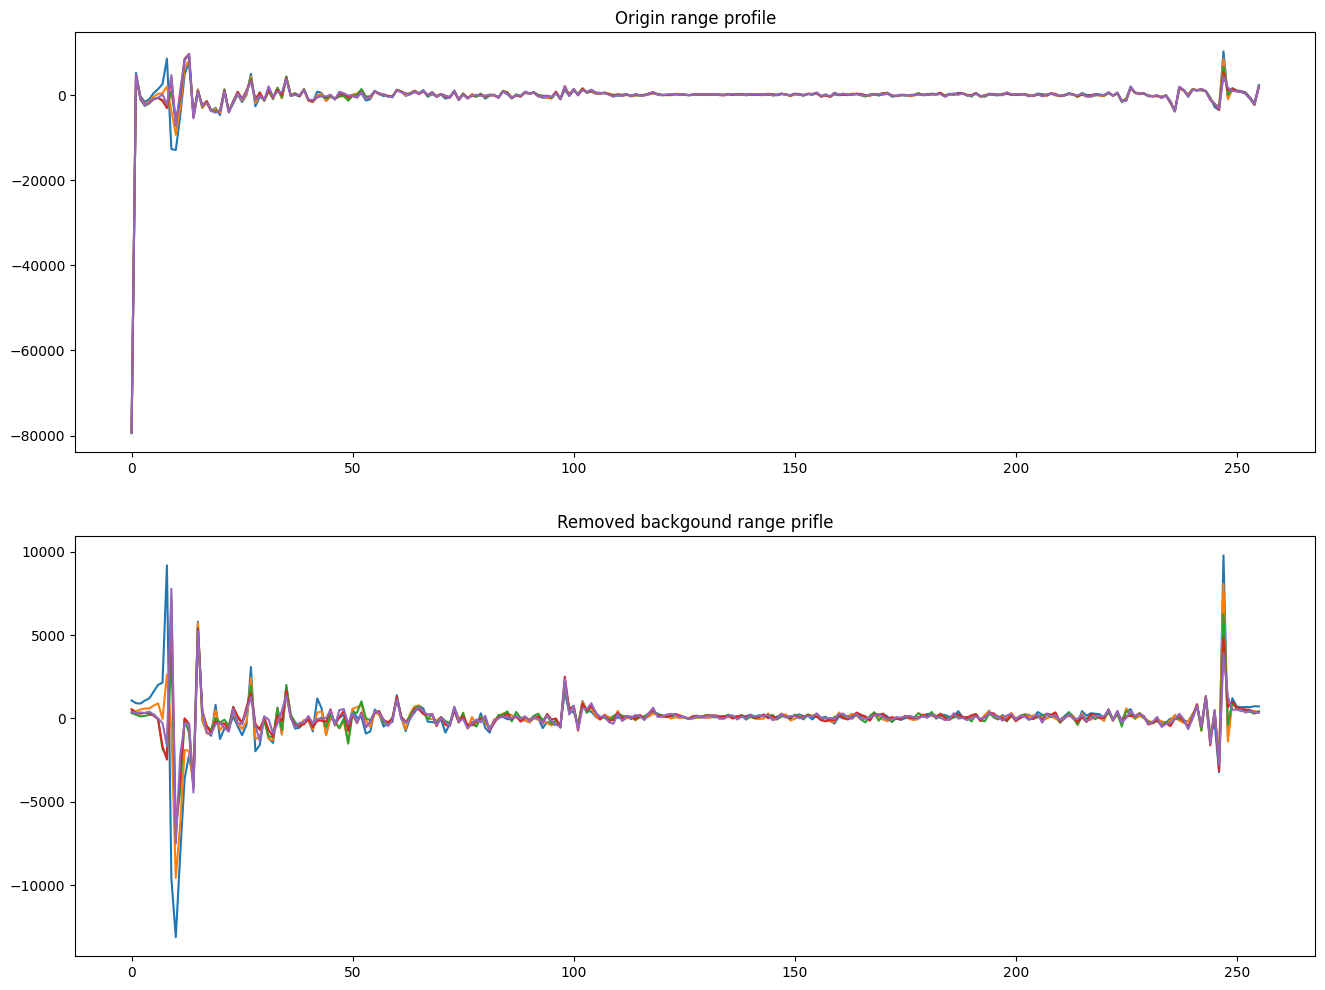

In [89]:
plt.figure(figsize=(16,12))
plt.subplot(211)
for i in range(0,5 ):
    plt.plot(range_profile[i])
plt.title("Origin range profile")

plt.subplot(212)
for j in range(0,5):
    plt.plot(removal_background_range_profile[j])
plt.title("Removed backgound range prifle")
plt.show()

In [90]:
def genetate3DSpectrum(the2DPlottingSignal):
    signals = the2DPlottingSignal
    num_signals =np.array(signals).shape[0]

    # Compute FFT for each signal in the array
    fft_results = np.fft.fft(signals, axis=1,)
    n = np.array(signals).shape[1]
    frequencies = np.fft.fftfreq(n)

    # Create grid for 3D plotting
    x = np.arange(num_signals)
    y = frequencies[:n//2]
    x, y = np.meshgrid(x, y)

    # Magnitude of the FFT components for the first half of the frequencies
    fft_magnitude = np.abs(fft_results[:, :n//2])
    
    # Plotting
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the 3D surface
    ax.plot_surface(x, y, fft_magnitude.T, cmap='viridis')

    ax.set_title('3D Magnitude Spectrum')
    ax.set_xlabel('Signal Index')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Magnitude')
    # ax.set_xticks(np.arange(num_signals))
    # ax.set_yticks(np.arange(min(y), max(y)+1, 20))  # Adjust y-axis ticks based on frequency range
    # ax.invert_xaxis()  # Invert x-axis for better visualization
    ax.view_init(elev=5, azim=5)  # Change the angles as desired
    plt.show()

In [91]:
def genetate3DRangeProfile(the2DRangeProfile):
    # signals = the2DRangeProfile
    num_range_profile =the2DRangeProfile.shape[0]
    range_profile_len =the2DRangeProfile.shape[1]

    # Compute FFT for each signal in the array

    frequencies = np.fft.fftfreq(range_profile_len)

    # Create grid for 3D plotting
    x = np.arange(num_range_profile)
    y = frequencies[:range_profile_len//2]
    x, y = np.meshgrid(x, y)

    # Magnitude of the FFT components for the first half of the frequencies
    fft_magnitude = np.abs(the2DRangeProfile[:, :range_profile_len//2])
    
    # Plotting
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the 3D surface
    ax.plot_surface(x, y, fft_magnitude.T, cmap='viridis')

    ax.set_title('3D Magnitude Spectrum')
    ax.set_xlabel('Signal Index')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Magnitude')
    # ax.set_xticks(np.arange(num_signals))
    # ax.set_yticks(np.arange(min(y), max(y)+1, 20))  # Adjust y-axis ticks based on frequency range
    # ax.invert_xaxis()  # Invert x-axis for better visualization
    ax.view_init(elev=5, azim=5)  # Change the angles as desired
    plt.show()

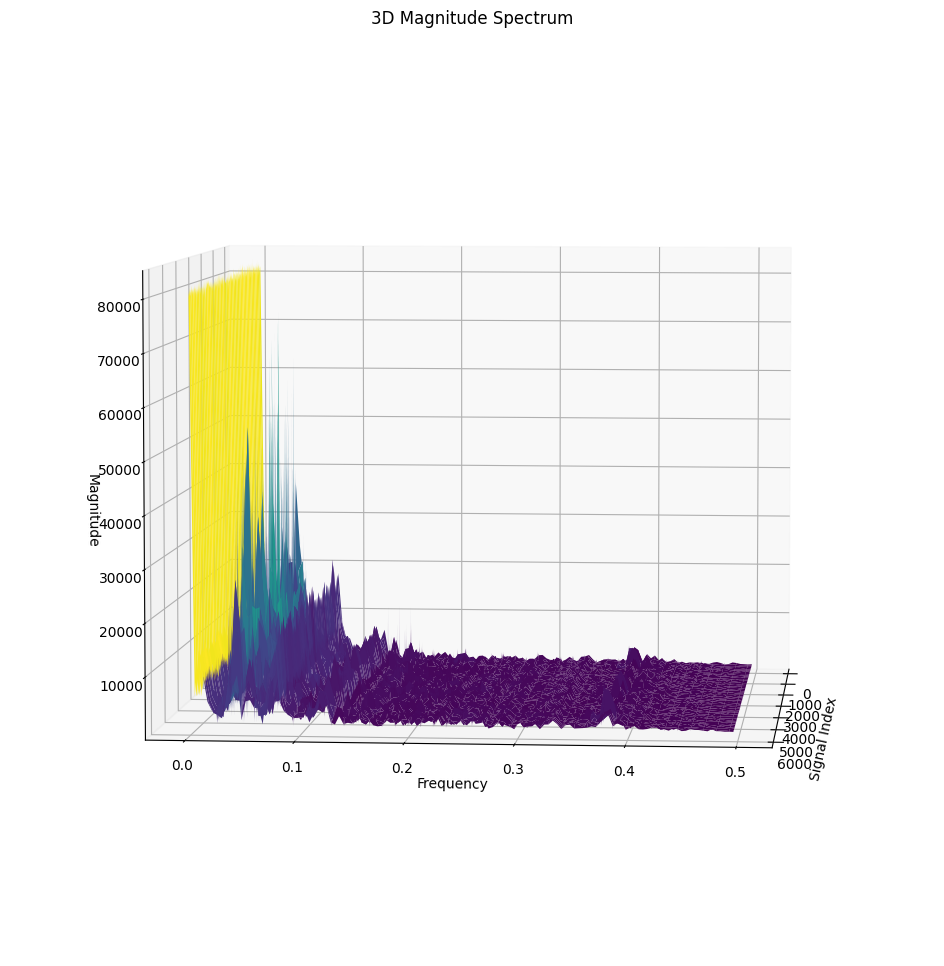

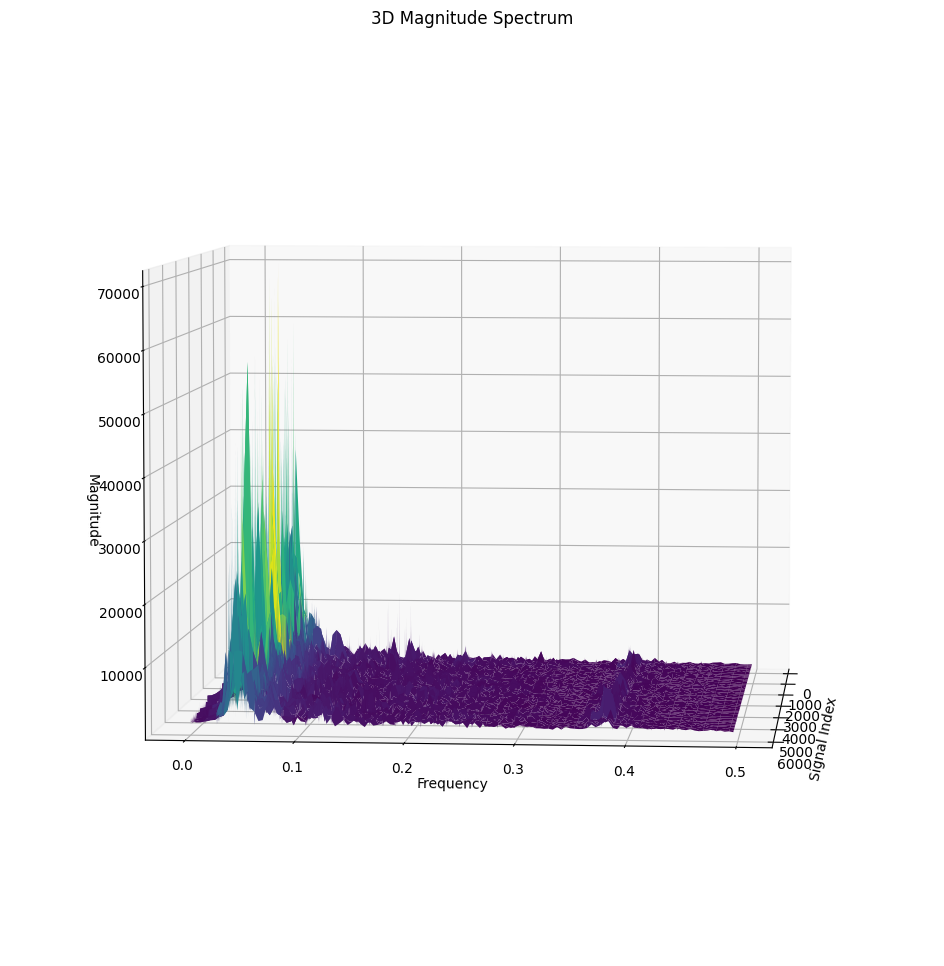

In [92]:
genetate3DRangeProfile(np.array(range_profile))
genetate3DRangeProfile(np.array(removal_background_range_profile))

In [93]:
magnitude_removal_background_range_profile =[np.abs(rm_backrange)  for rm_backrange in removal_background_range_profile]
print(np.array(magnitude_removal_background_range_profile).shape)
index_of_max_magnitude_each_frame=np.zeros((np.array(magnitude_removal_background_range_profile).shape)[0])
for magnitude in magnitude_removal_background_range_profile:
    max_index = np.argmax(magnitude)
    index_of_max_magnitude_each_frame[max_index]+=1

for i,count in enumerate(index_of_max_magnitude_each_frame):
    if(0!=count):
        print("[{0}] :{1}".format(i,count))
bin_of_interesting = np.argmax(index_of_max_magnitude_each_frame)
print("bin of interesting: {0}".format(bin_of_interesting))

interesting_bins = np.array([bin_of_interesting-1,bin_of_interesting,bin_of_interesting+1])
print(interesting_bins)

(6000, 256)
[6] :4.0
[7] :98.0
[8] :444.0
[9] :3573.0
[10] :1441.0
[11] :187.0
[12] :155.0
[13] :51.0
[14] :43.0
[15] :1.0
[16] :1.0
[32] :1.0
[36] :1.0
bin of interesting: 9
[ 8  9 10]


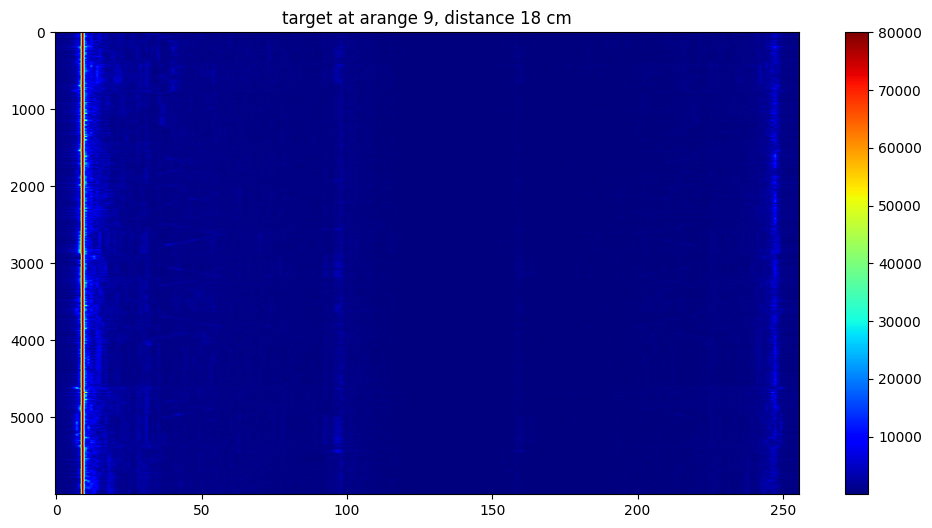

In [94]:
# extract phase
import copy
tmp =np.array(copy.deepcopy( magnitude_removal_background_range_profile ))
tmp[:,bin_of_interesting]=80000

plt.figure(figsize=(12,6))
plt.imshow(tmp,aspect='auto',cmap='jet')
plt.colorbar()
plt.title("target at arange {0}, distance {1} cm".format(bin_of_interesting, bin_of_interesting ))
plt.show()

9


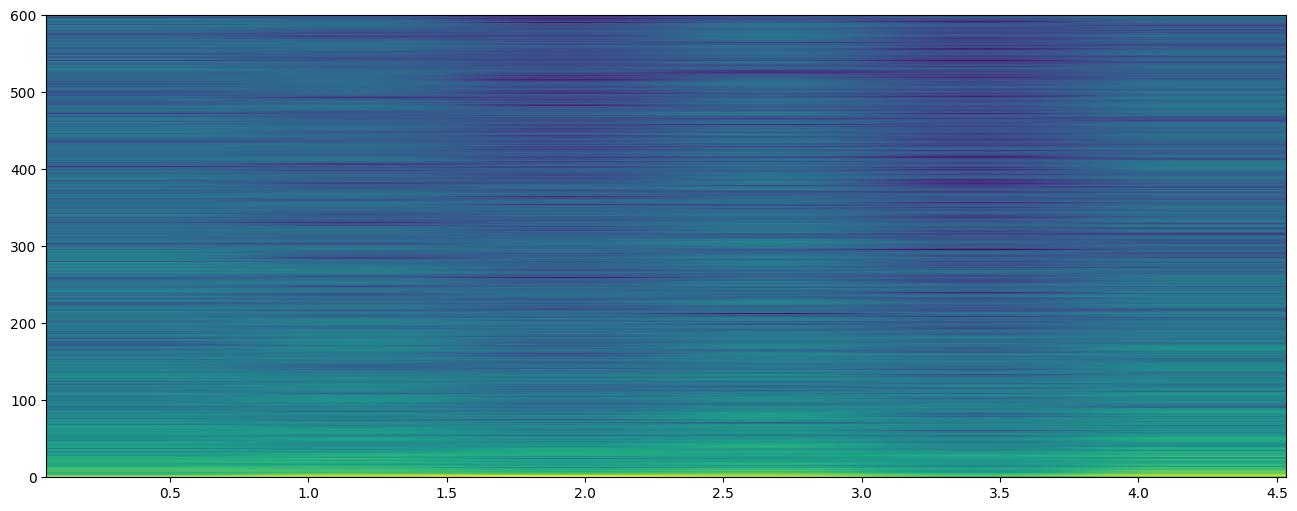

In [148]:
print(bin_of_interesting)
extracted_target_data = np.array(range_profile)[:,bin_of_interesting]
plt.figure(figsize=(16,6))
# plt.plot(extracted_target_data[:1200].real)
# plt.plot(extracted_target_data[:1200].imag)
angles_signal =np.unwrap( np.angle(extracted_target_data))
fft_angle =np.fft.fft(angles_signal)
# plt.plot(fft_angle)
plt.specgram(angles_signal,Fs=1200,NFFT=1024,noverlap=128)

plt.show()

In [113]:
def residuals(params, x1, x2):
    a, b, c = params
    return (x1 - a)**2 + (x2 - b)**2 - c

initial_params=np.array([0.5,0.5,0.5])
real_parts = []
imag_parts = []

for data in extracted_target_data:
    real_parts.append(data.real)
    imag_parts.append(data.imag)
one_chirp_result = least_squares(residuals, initial_params, args=(np.array(real_parts).flatten(), (np.array(imag_parts).flatten())))

a,b,c =one_chirp_result.x
DC_compensation =a+b*1j 
DC_corrected_extracted_target_data = [ (target_data_sample -DC_compensation) for target_data_sample  in extracted_target_data]

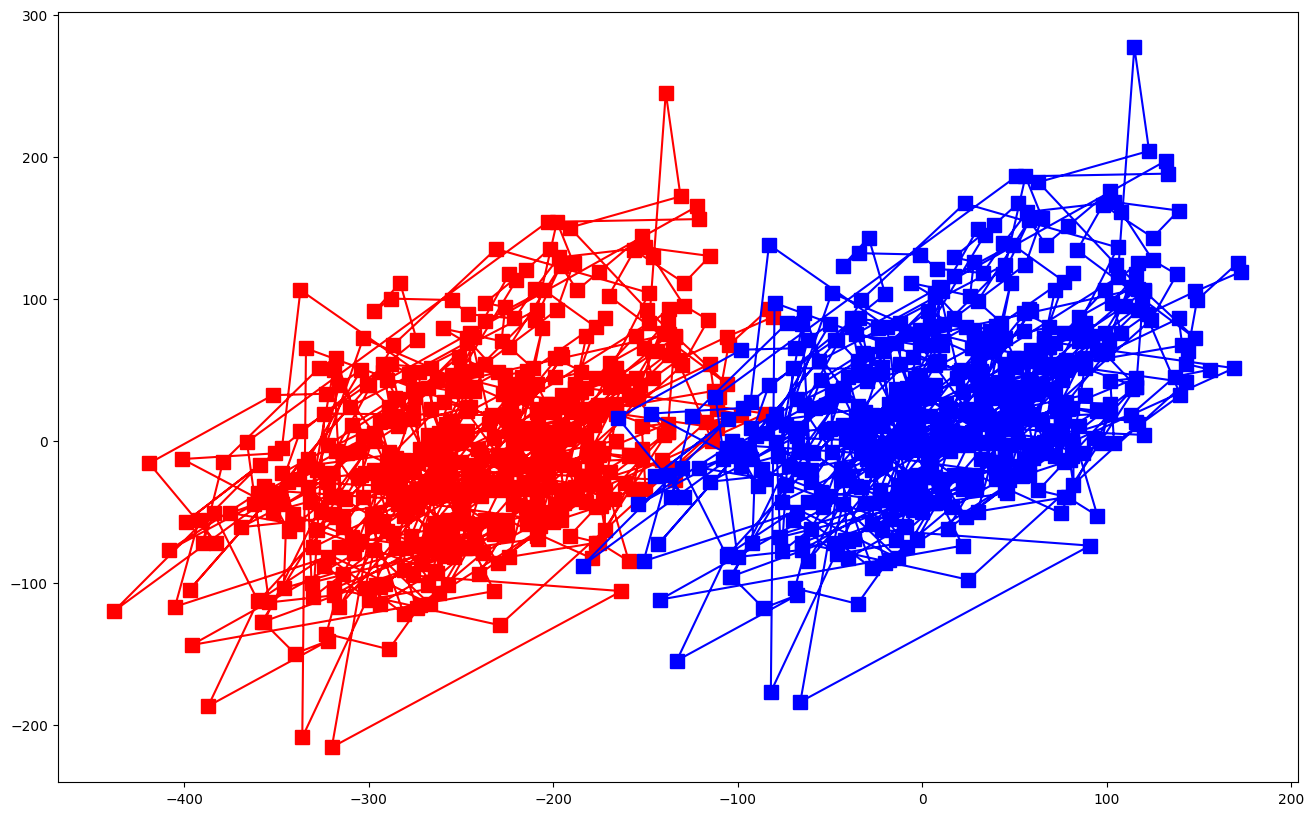

In [114]:

target_data_sample_real = [target_data_sample.real for target_data_sample in extracted_target_data[:600]]
target_data_sample_image =[target_data_sample.imag for target_data_sample in extracted_target_data[:600]]


DC_corrected_target_data_sample_real = [DC_corrected_target_data_sample.real for DC_corrected_target_data_sample in DC_corrected_extracted_target_data[:600]]
DC_corrected_target_data_sample_image =[DC_corrected_target_data_sample.imag for DC_corrected_target_data_sample in DC_corrected_extracted_target_data[:600]]


plt.figure(figsize=(16, 10))
plt.plot(target_data_sample_real, target_data_sample_image, 'rs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(target_data_sample_real, target_data_sample_image, color='red')

plt.plot(DC_corrected_target_data_sample_real, DC_corrected_target_data_sample_image, 'bs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(DC_corrected_target_data_sample_real, DC_corrected_target_data_sample_image, color='blue')
plt.show()

In [112]:
def extractPhase(interestingRangeBin):
    interestingRangeBinLen =len(interestingRangeBin)
    phaseExtracted = np.zeros(len(interestingRangeBin),dtype=float)
    phaseExtracted[0]=np.angle(interestingRangeBin[0])
    
    for i in range(1,interestingRangeBinLen):        
        tmpPhase =0
        for j in range(1,i):
            I_k=interestingRangeBin[j].real
            Q_k=interestingRangeBin[j].imag
            I_k_prev=interestingRangeBin[j-1].real
            Q_k_prev=interestingRangeBin[j-1].imag
            tmpPhase+= (I_k * (Q_k - Q_k_prev) -(I_k - I_k_prev)* Q_k)/(I_k**2 + Q_k **2)

        phaseExtracted[i]= tmpPhase
    return phaseExtracted

In [119]:
extracted_phase =extractPhase(np.array(DC_corrected_extracted_target_data))
extracted_phase_difference =np.diff(extracted_phase)

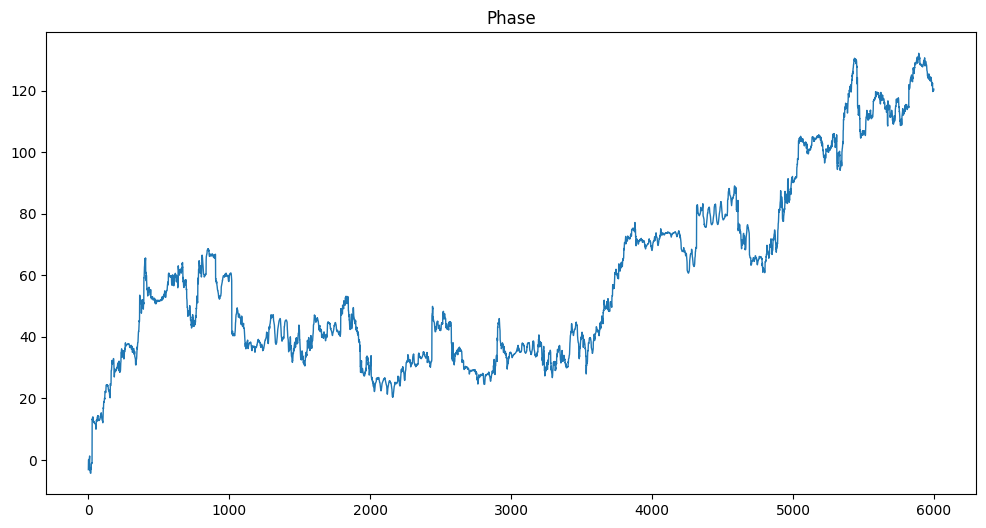

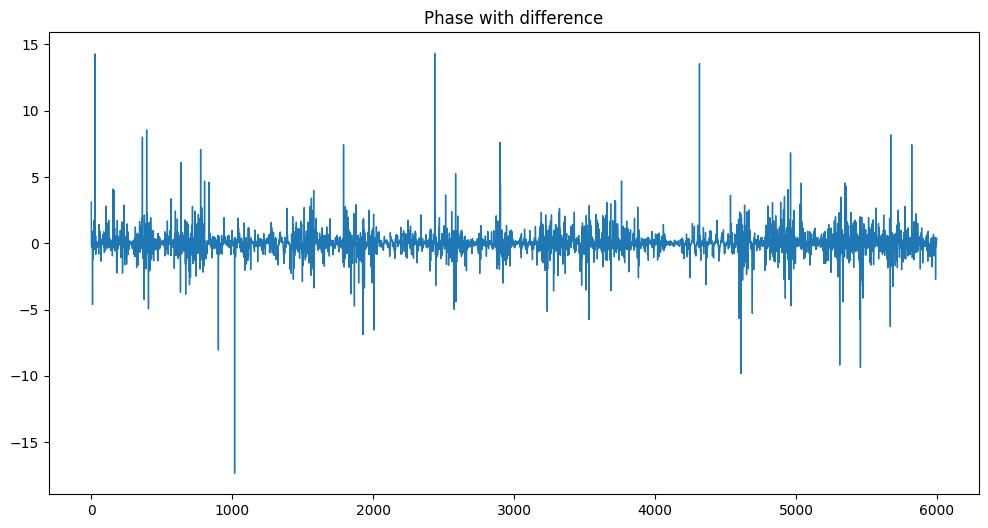

In [128]:
plt.figure(figsize=(12,6))
plt.plot(extracted_phase,linewidth=1)
plt.title("Phase")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(extracted_phase_difference,linewidth=1)
plt.title("Phase with difference")
plt.show()



(5999,)


(array([[6.38740313e+01, 1.65076446e+02, 3.33565408e+02, ...,
         1.81612789e+03, 1.89503852e+03, 1.84853497e+03],
        [3.87401263e+01, 8.99435510e+01, 2.01673168e+02, ...,
         8.35635376e+02, 9.90275833e+02, 9.04250683e+02],
        [8.63647876e-01, 5.49799371e-01, 5.94105817e+00, ...,
         3.86252206e+00, 6.56035430e-01, 1.99689838e-01],
        ...,
        [1.72252211e-04, 2.73687820e-04, 1.99810636e-04, ...,
         1.29740054e-04, 8.74987500e-04, 3.00135162e-05],
        [4.06235198e-04, 1.80804591e-05, 9.84513173e-04, ...,
         7.78915413e-05, 1.18343652e-03, 2.60116058e-04],
        [2.08463336e-05, 1.43830247e-04, 7.04698097e-04, ...,
         4.97020710e-05, 4.61274274e-04, 8.42245594e-06]]),
 array([  0.    ,   4.6875,   9.375 ,  14.0625,  18.75  ,  23.4375,
         28.125 ,  32.8125,  37.5   ,  42.1875,  46.875 ,  51.5625,
         56.25  ,  60.9375,  65.625 ,  70.3125,  75.    ,  79.6875,
         84.375 ,  89.0625,  93.75  ,  98.4375, 103.125 , 107

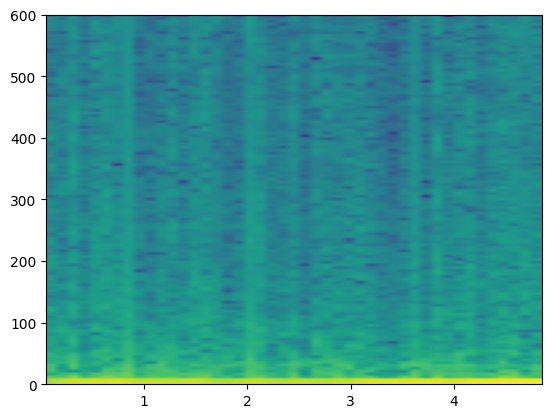

In [133]:


print(np.array(extracted_phase_difference).shape)
plt.specgram(extracted_phase,Fs=1200,NFFT=256,noverlap=128)


In [125]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = filtfilt(b, a, signal_to_filter)
    return signal_filtered

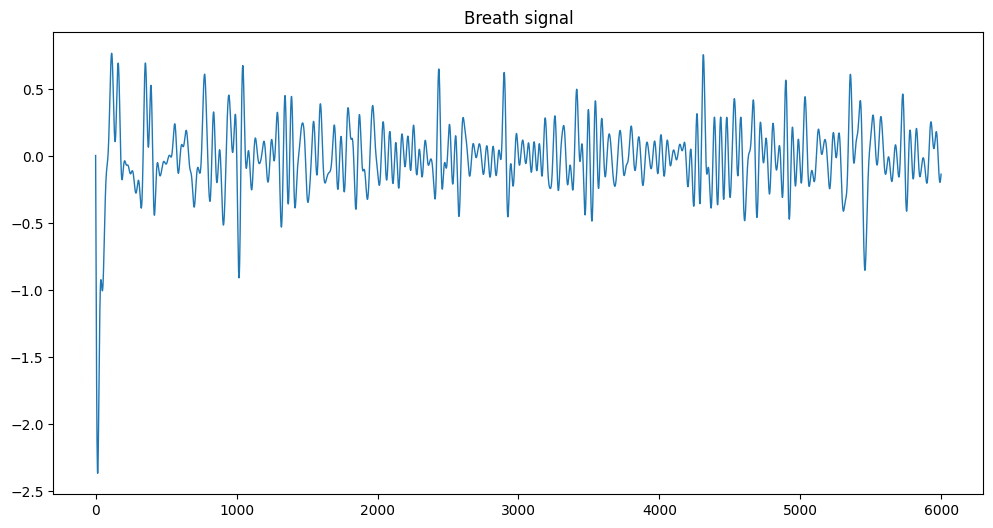

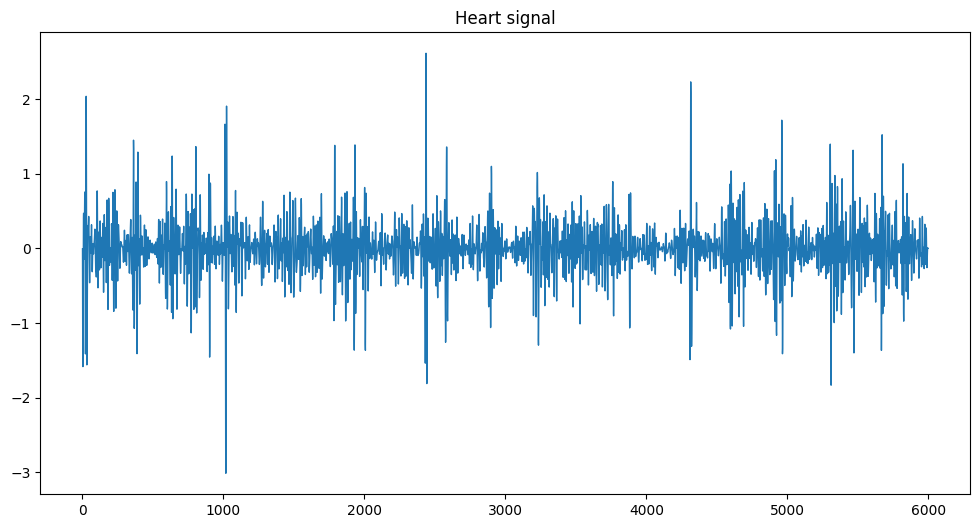

In [150]:
SR=1200/60
breath_band_filtering=[0.08,0.5]
breath_signal =filter_signal(np.array(extracted_phase_difference),breath_band_filtering[0],breath_band_filtering[1],SR,4)

heart_band_filtering =[0.8,2.5]
heart_signal =filter_signal(extracted_phase_difference,heart_band_filtering[0],heart_band_filtering[1],SR,4)

beath_heart_signal =filter_signal(extracted_phase_difference,0.08,2.5,SR,4)


plt.figure(figsize=(12,6))
plt.plot(breath_signal,linewidth=1)
plt.title("Breath signal")
plt.show()


plt.figure(figsize=(12,6))
plt.plot(heart_signal,linewidth=1)
plt.title("Heart signal")
plt.show()



In [153]:
spectrogram(beath_heart_signal,Fs=1200,NFFT=512,noverlap=128)
# plt.show()
print(np.array(beath_heart_signal).shape)

(5999,)
